<a href="https://colab.research.google.com/github/lele25811/Vehicle-ReId/blob/main/Color_Type_VeRi_ReiD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Re-identificazione delle etichette `Color_id` e `Type_id`
* Dataset: VeRi (https://github.com/VehicleReId/VeRi)
> download from google drive: https://drive.google.com/file/d/0B0o1ZxGs_oVZWmtFdXpqTGl3WUU/view?pli=1&resourcekey=0-YIcgC3HmQD7QnvoMpmfczA

* Model: ResNet50


# 1. Download datasets

In [1]:
# Monto il mio google drive (una volta montanto il contenuto di google drive sarà accessibile nella directory `/content/drive/My Drive`)
from google.colab import drive
!mkdir -p drive/
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Indoviduo il path del dataset
dataset_path = "/content/drive/MyDrive/datasets/VeRi.zip"

In [3]:
# Creo la cartella `data`
!mkdir -p data/

In [4]:
# Copio il file nel Workspace
!cp "/content/drive/MyDrive/datasets/VeRi.zip" /content/

In [5]:
# Controllo il tipo di file scaricato
!file VeRi.zip

VeRi.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [6]:
# Decomprimo il file zip
!unzip -q /content/VeRi.zip -d data

# Organizzazione Dataset

### 1. Parsing del file XML

Estraiamo le informazioni rilevanti dal file XML e le memorizziamo in un DataFrame Pandas
* train_labels_df
* test_labels_df

che contengono:
* nome immagine
* Vehicle ID
* Camera ID
* Color ID
* Type ID

In [7]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_labels(label_path):
    # Lista per memorizzare i dati
    data = []

    # Aprire il file con la codifica esplicita
    with open(label_path, "r", encoding="ascii", errors="ignore") as f:
      content = f.read() # Leggi il contenuto ignorando gli errori

      try:
        tree = ET.ElementTree(ET.fromstring(content))  # Parso direttamente il contenuto
        root = tree.getroot()  # Ottieni il nodo radice
        # Iterare attraverso i nodi Item
        for item in root.find('Items').findall("Item"):
          image_name = item.get("imageName")
          vehicle_id = item.get("vehicleID")
          camera_id = item.get("cameraID")
          color_id = item.get("colorID")
          type_id = item.get("typeID")

          # Aggiungere i dati alla lista
          data.append({
            "image_name": image_name,
            "vehicle_id": int(vehicle_id),
            "camera_id": camera_id,
            "color_id": int(color_id),
            "type_id": int(type_id)
          })
      except ET.ParseError as e:
        print(f"Errore di parsing: {e}")
        return {}

    return pd.DataFrame(data)

# Percorso al file XML
train_label_path = "/content/data/VeRi/train_label.xml"
test_label_path = "/content/data/VeRi/test_label.xml"

# Creo un dataframe per le immagini di train e test
train_labels_df = parse_labels(train_label_path)
test_labels_df = parse_labels(test_label_path)

# Recupero le dimensioni dei dataset (righe e colonne)
train_df_rows, train_df_cols = train_labels_df.shape
test_df_rows, test_df_cols = test_labels_df.shape

print(f"train dataframe -> rows: {train_df_rows}, cols: {train_df_cols}")
print(f"test dataframe -> rows: {test_df_rows}, cols: {test_df_cols}")

train dataframe -> rows: 37746, cols: 5
test dataframe -> rows: 11579, cols: 5


In [8]:
# Controlliamo i primi elementi per confermare che le colonne siano riempite correttamente
print(train_labels_df.head())
print(test_labels_df.head())

                 image_name  vehicle_id camera_id  color_id  type_id
0  0001_c001_00016450_0.jpg           1      c001         1        4
1  0001_c001_00016460_0.jpg           1      c001         1        4
2  0001_c001_00016470_0.jpg           1      c001         1        4
3  0001_c001_00016480_0.jpg           1      c001         1        4
4  0001_c001_00016490_0.jpg           1      c001         1        4
                 image_name  vehicle_id camera_id  color_id  type_id
0  0002_c002_00030600_0.jpg           2      c002         1        4
1  0002_c002_00030605_1.jpg           2      c002         1        4
2  0002_c002_00030615_1.jpg           2      c002         1        4
3  0002_c002_00030625_1.jpg           2      c002         1        4
4  0002_c002_00030640_0.jpg           2      c002         1        4


In [9]:
# Controlliamo che non ci siano valori nulli (stampa quanti NULL ci sono)
print(train_labels_df.isnull().sum())
print(test_labels_df.isnull().sum())

image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64
image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64


In [10]:
print("Color ID unici:", train_labels_df["color_id"].nunique())
print("Type ID unici:", train_labels_df["type_id"].nunique())

Color ID unici: 10
Type ID unici: 9


### 2. Preprocessing delle immagini

In [11]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ridimensiona
    transforms.ToTensor(),          # Converti in tensore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizza
])

### 3. Creazione di un dataset personalizzato
Creazione di una classe `VeRiDataset` personalizzata per il Dataset in PyTorch che utilizza i DataFrame e carica le immagini.
È progettata per caricare immagini, applicare le trasformazioni e restituire i dati in un formato compatibile con PyTorch per il training e il testing.

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import os

class VeRiDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    # ritorna il numero di campioni del dataset
    def __len__(self):
        return len(self.dataframe)

    # Recupera un campione nel dataset e ritorna l'immagine preprocessata (torch.Tensor) e l'etichetta corrispondente (ID del veicolo: int)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image_name"])
        image = Image.open(img_path).convert("RGB")

        # Etichette associate all'immagine
        labels = {
            "vehicle_id": row["vehicle_id"],
            "camera_id": row["camera_id"],
            "color_id": row["color_id"],
            "type_id": row["type_id"]
        }


        if self.transform:
            image = self.transform(image)

        return image, labels

In [13]:
train_dataset = VeRiDataset(train_labels_df, "/content/data/VeRi/image_train", transform=transform)
test_dataset = VeRiDataset(test_labels_df, "/content/data/VeRi/image_test", transform=transform)

# 3.1 Stampa di un immagine di prova con le rispettive etichette

In [14]:
# Funzione che mappa, per ogni file dove serve, l'ID con etichetta corrispondente
def load_mapping(file_path):
    mapping = {}
    with open(file_path, "r") as f:
        for line in f:
            key, value = line.strip().split(" ", 1)
            mapping[int(key)] = value
    return mapping

color_mapping = load_mapping("data/VeRi/list_color.txt")
type_mapping = load_mapping("data/VeRi/list_type.txt")

print("Mappa del colore:", color_mapping)
print("Mappa del tipo:", type_mapping)

Mappa del colore: {1: 'yellow', 2: 'orange', 3: 'green', 4: 'gray', 5: 'red', 6: 'blue', 7: 'white', 8: 'golden', 9: 'brown', 10: 'black'}
Mappa del tipo: {1: 'sedan', 2: 'suv', 3: 'van', 4: 'hatchback', 5: 'mpv', 6: 'pickup', 7: 'bus', 8: 'truck', 9: 'estate'}


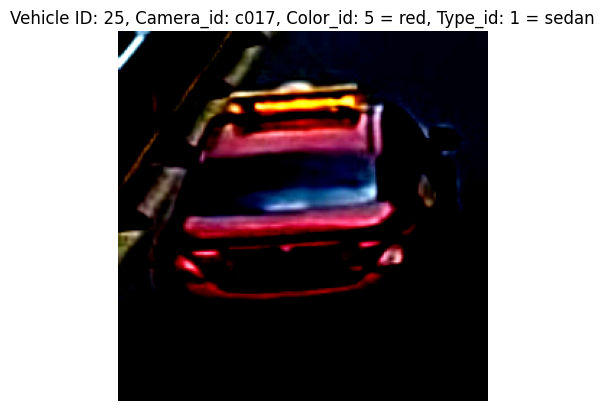

In [15]:
import torch
import random
import matplotlib.pyplot as plt

def show_random_image(dataset):
    # Estrai un indice casuale
    random_idx = random.randint(0, len(dataset) - 1)

    # Recupera l'immagine e l'etichetta corrispondente
    image, labels = dataset[random_idx]
    vehicle_id = labels["vehicle_id"]
    camera_id = labels["camera_id"]
    color_id = labels["color_id"]
    type_id = labels["type_id"]

    # Se l'immagine è un tensore (torch.Tensor), convertila in formato PIL
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Cambia l'ordine dei canali per matplotlib

    # Stampa l'immagine con le etichette
    plt.imshow(image)
    plt.title(f"Vehicle ID: {vehicle_id}, Camera_id: {camera_id}, Color_id: {color_id} = {color_mapping[color_id]}, Type_id: {type_id} = {type_mapping[type_id]}")
    plt.axis('off')
    plt.show()

# Esegui la funzione sul train_dataset
show_random_image(train_dataset)

## 3.2 Creazione dei DataLoader
In PyTorch il **DataLoader** è una classe che permette di iterare in modo efficiente sul dataset, suddividendolo in mini-batch.
Un **batch** è un sottinsieme del dataset completo che viene elaborato dal modello in una singola iterazione.

**DataLoader()**:
* Dataset: il dataset che deve essere iterato
* batch_size: Numero di immagini per batch
* shuffle: Mescola i dati (True/False)
* Numero di thread per il caricamento parallelo dei dati

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. Caricamento del modello

Modifica della rete ResNet50 che crea un modello che esegue Classificazione multi-output, ovvero prevede più categorie (id veicolo, colore e tipo) data un'unica immagine di input.

In [17]:
import torch
import torch.nn as nn
from torchvision import models

class MultiOutputResNet50(nn.Module):
    def __init__(self, num_colors, num_types):
        super(MultiOutputResNet50, self).__init__()
        # Carica il modello ResNet50 pre-allenato su ImageNet
        self.backbone = models.resnet50(pretrained=True)
        #self.backbone = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V2)

        # ResNet 50 ha una struttura con più blocchi di cui l'ultimo è un layer lineare
        # `list(self.backbone.children())[:-1]` converte i blocchi del modello in una lista, esclude l'ultimo layer fully connected (fc) che è specifico per ImageNet
        # Con `nn.Sequential` ricrea la rete con i layer fino al penultimo (il blocco genera features da 2048 dimensioni)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # "Teste" per le diverse classificazioni
        # `nn.Linear(2048, n)` Layer fully connected (fc) che mappa i 2048 feature in n classi
        # n = singole classi da predire
        self.fc_color = nn.Linear(2048, num_colors)
        self.fc_type = nn.Linear(2048, num_types)

    def forward(self, x):
        # L'input x ha dimensioni [batch_size, 3, H, W]
        # Il backbone elabora l'input producendo un tensore di feature [batch_size, 2048, 1, 1]
        features = self.backbone(x)

        # Appiattisce le feature da 4 dimensioni a 2 dimensioni: da [batch_size, 2048, 1, 1] a [batch_size, 2048]
        features = torch.flatten(features, 1)

        # Calcola i logit per ciascuna delle tre teste
        color_logits = self.fc_color(features)
        type_logits = self.fc_type(features)

        return color_logits, type_logits

In [18]:
print("Train labels vehicles id ", train_labels_df["vehicle_id"].unique())
print("Test labels vehicles id ", test_labels_df["vehicle_id"].unique())
print("Color labels id ", train_labels_df["color_id"].unique())
print("Map of Color id ", color_mapping)
print("Type labels id ", train_labels_df["type_id"].unique())
print("Map of Type id ", type_mapping)

Train labels vehicles id  [  1   3   4   7   8  10  11  12  13  15  16  17  18  19  20  21  22  23
  24  25  26  28  29  31  32  33  34  36  37  39  40  41  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  62  64  67  68
  69  70  71  72  73  75  76  77  78  79  80  81  82  83  84  85  87  88
  91  92  93  94  95  97  98  99 100 103 107 109 111 112 114 115 116 119
 120 121 123 124 125 127 128 131 133 136 137 138 139 140 141 146 147 148
 149 152 153 155 156 157 158 159 160 161 163 164 165 167 168 169 170 171
 175 176 178 181 184 185 186 187 189 190 191 193 194 195 198 199 200 201
 202 203 204 206 208 209 210 211 212 213 214 215 217 220 221 222 223 224
 225 226 227 228 229 230 232 233 234 235 236 238 239 242 243 244 245 246
 248 250 251 252 253 254 255 256 257 258 259 260 261 263 264 265 266 267
 268 269 270 271 272 274 275 276 277 278 279 280 282 283 284 285 286 287
 289 290 291 292 293 297 301 302 303 304 305 307 308 309 311 312 313 314
 316 317 320 321 323 324 

`pandas.DataFrame.nunique()`: Conta il numero di elementi distinti in uno specifico asse (default: axis=0)

In [19]:
# Numero di classi per ogni tipo di etichetta
num_vehicle_ids_train = train_labels_df["vehicle_id"].nunique()
num_vehicle_ids_test = test_labels_df["vehicle_id"].nunique()
total_num_vehicle = num_vehicle_ids_train + num_vehicle_ids_test

num_colors = train_labels_df["color_id"].nunique()+1
num_types = train_labels_df["type_id"].nunique()+1

# Inizializza il modello
model = MultiOutputResNet50(num_colors, num_types)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Sposta il modello sul dispositivo

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.2MB/s]


MultiOutputResNet50(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

# 5. Definizione di loss function e optimizer

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. Definizione di train e eval del modello

In [21]:
from tqdm.auto import tqdm

# train step
def train_step(model, dataloader, loss_fn, optimizer, device=device):
    model.train()
    running_loss = 0.0
    correct_color = 0
    correct_type = 0
    total_samples = 0

    for images, labels in tqdm(dataloader, desc="Training..."):
        # Sposta i dati sul device
        images = images.to(device)
        color_labels = labels["color_id"].to(device)
        type_labels = labels["type_id"].to(device)

        # Azzeriamo i gradienti
        optimizer.zero_grad()

        # Forward pass
        color_logits, type_logits = model(images)

        # Calcolo della perdita
        loss_color = loss_fn(color_logits, color_labels)
        loss_type = loss_fn(type_logits, type_labels)
        loss = loss_color + loss_type

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Aggiorna le metriche
        running_loss += loss.item()
        _, color_preds = torch.max(color_logits, 1)
        _, type_preds = torch.max(type_logits, 1)

        correct_color += (color_preds == color_labels).sum().item()
        correct_type += (type_preds == type_labels).sum().item()
        total_samples += images.size(0)

    # Calcolo della loss media e accuratezza
    avg_loss = running_loss / len(dataloader)
    accuracy_color = correct_color / total_samples
    accuracy_type = correct_type / total_samples

    return avg_loss, accuracy_color, accuracy_type

# test step
def test_step(model, dataloader, loss_fn, device=device):
    model.eval()
    running_loss = 0.0
    correct_color = 0
    correct_type = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating..."):
            # Sposta i dati sul device
            images = images.to(device)
            color_labels = labels["color_id"].to(device)
            type_labels = labels["type_id"].to(device)

            # Forward pass
            color_logits, type_logits = model(images)

            # Calcolo della perdita
            loss_color = loss_fn(color_logits, color_labels)
            loss_type = loss_fn(type_logits, type_labels)
            loss = loss_color + loss_type

            # Aggiorna le metriche
            running_loss += loss.item()
            _, color_preds = torch.max(color_logits, 1)
            _, type_preds = torch.max(type_logits, 1)

            correct_color += (color_preds == color_labels).sum().item()
            correct_type += (type_preds == type_labels).sum().item()
            total_samples += images.size(0)

    # Calcolo della loss media e accuratezza
    avg_loss = running_loss / len(dataloader)
    accuracy_color = correct_color / total_samples
    accuracy_type = correct_type / total_samples

    return avg_loss, accuracy_color, accuracy_type

# train loop
def train(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device=device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training step
        train_loss, train_acc_color, train_acc_type = train_step(
            model, train_loader, loss_fn, optimizer)

        # Testing step
        test_loss, test_acc_color, test_acc_type = test_step(
            model, test_loader, loss_fn)

        # Salva le metriche
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append((train_acc_color, train_acc_type))
        test_accuracies.append((test_acc_color, test_acc_type))

        # Log dei risultati
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Train Accuracies -> Color: {train_acc_color:.4f}, Type: {train_acc_type:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracies -> Color: {test_acc_color:.4f}, Type: {test_acc_type:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies


# 7. Training del modello

In [22]:
from torch.utils.data import DataLoader

train_losses, test_losses, train_accuracies, test_accuracies = train(model, train_loader, test_loader, loss_fn, optimizer, 20)


Epoch 1/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.9693
Train Accuracies -> Color: 0.8580, Type: 0.8218
Test Loss: 0.9124
Test Accuracies -> Color: 0.9075, Type: 0.8202

Epoch 2/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.4073
Train Accuracies -> Color: 0.9387, Type: 0.9224
Test Loss: 0.7353
Test Accuracies -> Color: 0.9147, Type: 0.8879

Epoch 3/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.2501
Train Accuracies -> Color: 0.9611, Type: 0.9540
Test Loss: 0.8531
Test Accuracies -> Color: 0.9114, Type: 0.8847

Epoch 4/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.1773
Train Accuracies -> Color: 0.9713, Type: 0.9678
Test Loss: 0.6991
Test Accuracies -> Color: 0.9340, Type: 0.9017

Epoch 5/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.1417
Train Accuracies -> Color: 0.9770, Type: 0.9739
Test Loss: 0.8291
Test Accuracies -> Color: 0.9150, Type: 0.8787

Epoch 6/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.1086
Train Accuracies -> Color: 0.9814, Type: 0.9808
Test Loss: 0.7346
Test Accuracies -> Color: 0.9345, Type: 0.9143

Epoch 7/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0931
Train Accuracies -> Color: 0.9846, Type: 0.9841
Test Loss: 0.7085
Test Accuracies -> Color: 0.9184, Type: 0.9217

Epoch 8/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0749
Train Accuracies -> Color: 0.9877, Type: 0.9873
Test Loss: 0.8364
Test Accuracies -> Color: 0.9369, Type: 0.8963

Epoch 9/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0689
Train Accuracies -> Color: 0.9893, Type: 0.9879
Test Loss: 0.6603
Test Accuracies -> Color: 0.9353, Type: 0.9164

Epoch 10/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0565
Train Accuracies -> Color: 0.9906, Type: 0.9904
Test Loss: 0.6734
Test Accuracies -> Color: 0.9459, Type: 0.9104

Epoch 11/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0517
Train Accuracies -> Color: 0.9913, Type: 0.9919
Test Loss: 0.6960
Test Accuracies -> Color: 0.9383, Type: 0.9127

Epoch 12/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0518
Train Accuracies -> Color: 0.9923, Type: 0.9903
Test Loss: 0.9721
Test Accuracies -> Color: 0.9343, Type: 0.8946

Epoch 13/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0380
Train Accuracies -> Color: 0.9937, Type: 0.9940
Test Loss: 0.8200
Test Accuracies -> Color: 0.9332, Type: 0.9136

Epoch 14/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0395
Train Accuracies -> Color: 0.9926, Type: 0.9952
Test Loss: 0.7073
Test Accuracies -> Color: 0.9424, Type: 0.9247

Epoch 15/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0318
Train Accuracies -> Color: 0.9949, Type: 0.9943
Test Loss: 1.0581
Test Accuracies -> Color: 0.9444, Type: 0.9002

Epoch 16/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0357
Train Accuracies -> Color: 0.9937, Type: 0.9945
Test Loss: 0.7870
Test Accuracies -> Color: 0.9329, Type: 0.9222

Epoch 17/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0322
Train Accuracies -> Color: 0.9950, Type: 0.9943
Test Loss: 0.7432
Test Accuracies -> Color: 0.9485, Type: 0.9240

Epoch 18/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0294
Train Accuracies -> Color: 0.9952, Type: 0.9961
Test Loss: 0.9876
Test Accuracies -> Color: 0.9352, Type: 0.9012

Epoch 19/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0265
Train Accuracies -> Color: 0.9956, Type: 0.9963
Test Loss: 0.9230
Test Accuracies -> Color: 0.9382, Type: 0.9073

Epoch 20/20


Training...:   0%|          | 0/1180 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.0260
Train Accuracies -> Color: 0.9958, Type: 0.9959
Test Loss: 0.8739
Test Accuracies -> Color: 0.9326, Type: 0.9098


# Accuratezza e Overfitting misurano cose diverse

* **Overfitting**: Si riferisce alla capacità del modello di generalizzare dai dati di training ai dati di test. Lo osservi analizzando la discrepanza tra il training loss e il test loss.
* **Accuratezza**: Misura la percentuale di predizioni corrette (ad esempio, la classificazione del colore o del tipo del veicolo). Anche se il modello sta "memorizzando" i dati, potrebbe ancora essere in grado di fare predizioni corrette perché alcune caratteristiche apprese dai dati di training sono utili anche nei dati di test.

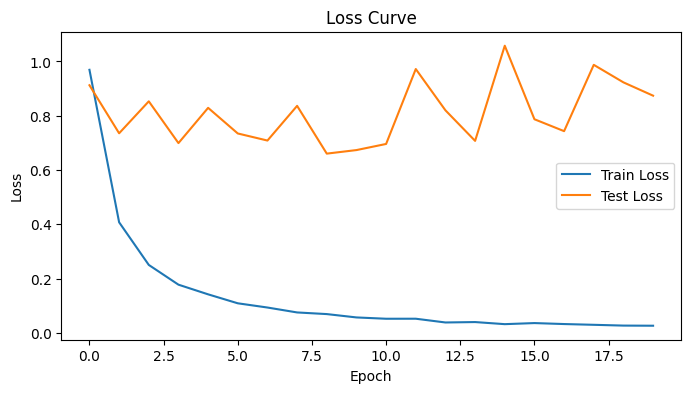

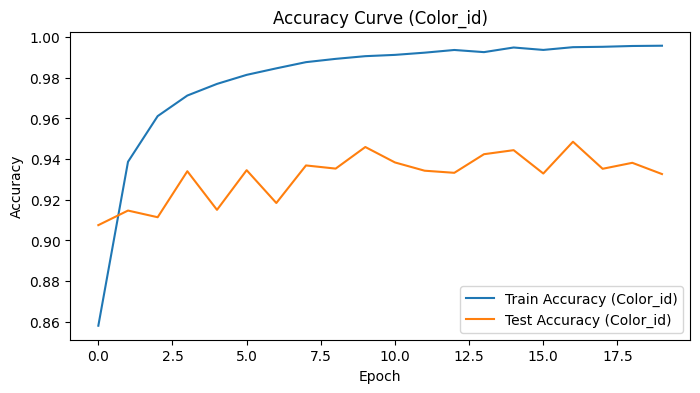

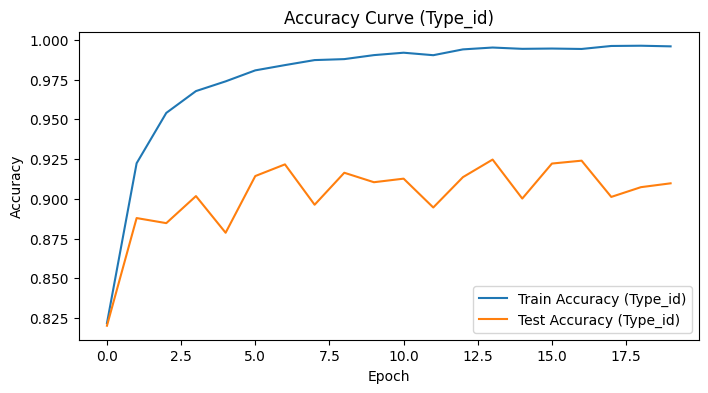

In [23]:
import matplotlib.pyplot as plt

# Plot delle perdite
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot dell'accuratezza (ad esempio per 'color_id')
train_acc_color = [x[0] for x in train_accuracies]
test_acc_color = [x[0] for x in test_accuracies]

plt.figure(figsize=(8, 4))
plt.plot(train_acc_color, label="Train Accuracy (Color_id)")
plt.plot(test_acc_color, label="Test Accuracy (Color_id)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve (Color_id)")
plt.show()

# Plot dell'accuratezza (ad esempio per 'type_id')
train_acc_type = [x[1] for x in train_accuracies]
test_acc_type = [x[1] for x in test_accuracies]

plt.figure(figsize=(8, 4))
plt.plot(train_acc_type, label="Train Accuracy (Type_id)")
plt.plot(test_acc_type, label="Test Accuracy (Type_id)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve (Type_id)")
plt.show()

# 8. Salvataggio modello

In [24]:
# Percorso dove salvare il modello
model_save_path = "/content/trained_model.pth"

# Salva i pesi del modello
torch.save(model.state_dict(), model_save_path)
print(f"Modello salvato in {model_save_path}")

Modello salvato in /content/trained_model.pth


# 9. Test del Modello

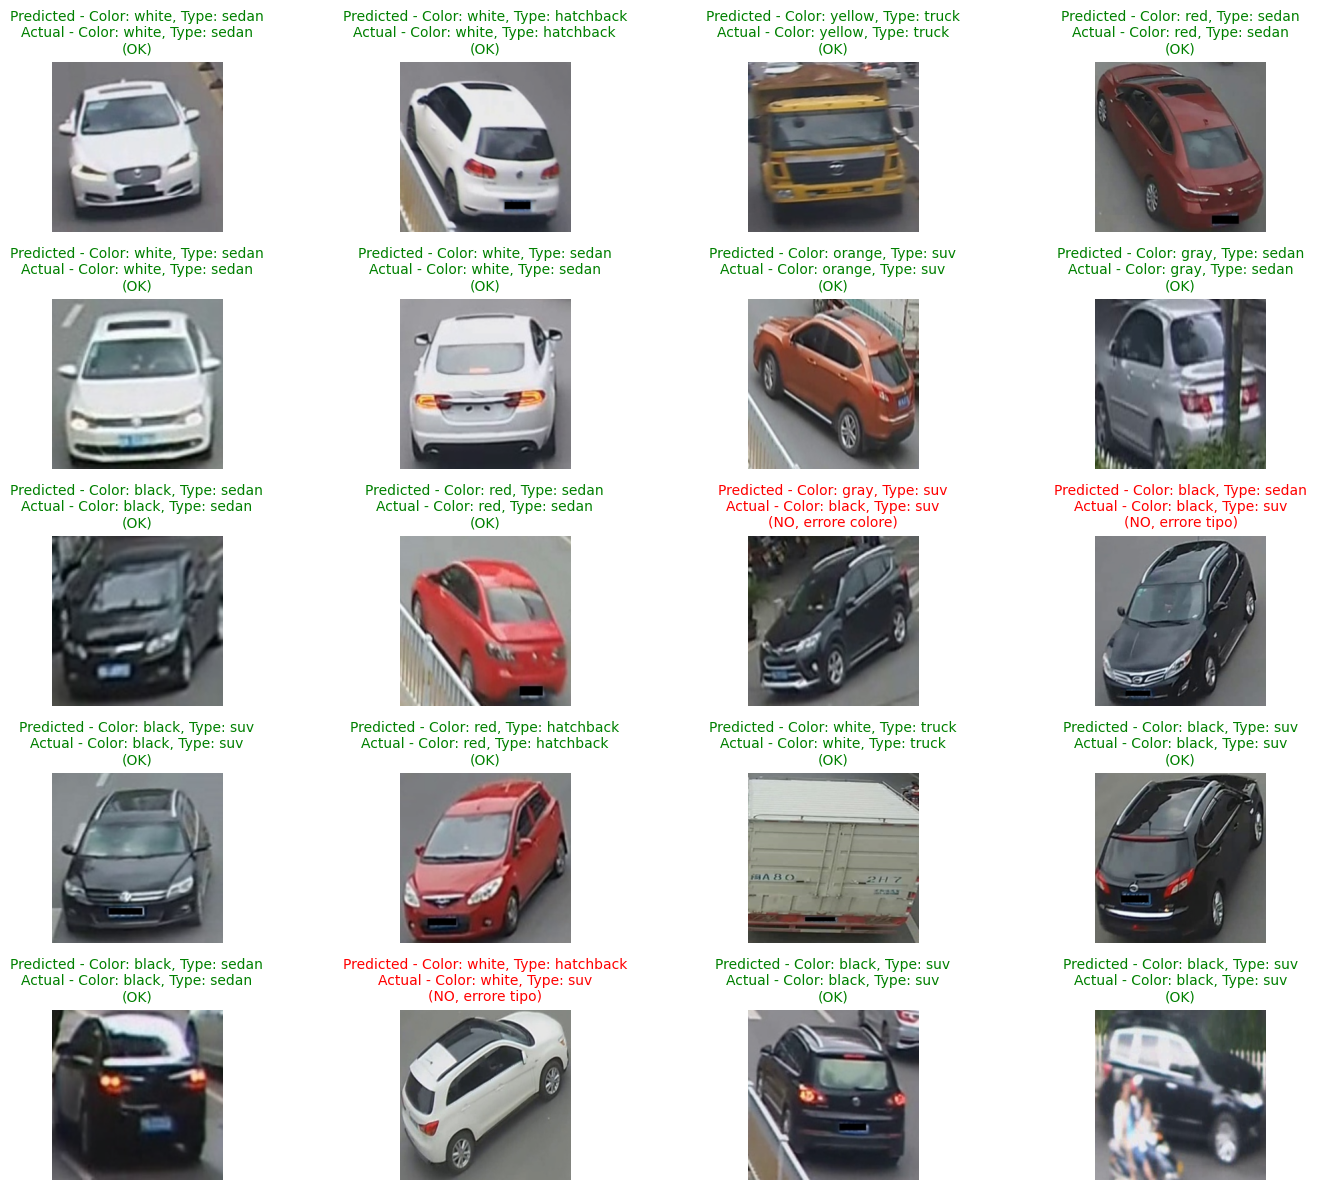

In [25]:
import random
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def test_model_on_random_images(model, dataloader, device=device, num_images=20):
    model.eval()  # Imposta il modello in modalità di valutazione
    random.seed(42)  # Per riproducibilità
    images_checked = 0
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    ])  # Trasformazione per riportare l'immagine originale

    plt.figure(figsize=(15, 12))  # Imposta dimensione della griglia

    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        for images, labels in dataloader:
            # Sposta immagini e etichette su device
            images = images.to(device)
            color_labels = labels["color_id"].to(device)
            type_labels = labels["type_id"].to(device)

            # Predizione del modello
            color_logits, type_logits = model(images)
            _, predicted_color = color_logits.max(1)
            _, predicted_type = type_logits.max(1)

            # Itera sulle immagini di questo batch
            for i in range(images.size(0)):
                if images_checked >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return  # Stop quando abbiamo testato abbastanza immagini

                # Estrai l'immagine corrente e de-normalizzala per la visualizzazione
                img = images[i].cpu()
                img = unnormalize(img)
                img = img.permute(1, 2, 0).clamp(0, 1).numpy()  # Cambia ordine dimensioni per plt.imshow

                # Determina se la predizione è corretta per color e type
                correct_color = predicted_color[i].item() == color_labels[i].item()
                correct_type = predicted_type[i].item() == type_labels[i].item()

                # Determina il tipo di errore
                if not correct_color and not correct_type:
                    error_message = "NO, errore colore e tipo"
                elif not correct_color:
                    error_message = "NO, errore colore"
                elif not correct_type:
                    error_message = "NO, errore tipo"
                else:
                    error_message = "OK"

                # Genera il titolo con il colore appropriato
                title_color = 'green' if correct_color and correct_type else 'red'
                title = (
                    f"Predicted - Color: {color_mapping[predicted_color[i].item()]}, Type: {type_mapping[predicted_type[i].item()]}\n"
                    f"Actual - Color: {color_mapping[color_labels[i].item()]}, Type: {type_mapping[type_labels[i].item()]}\n"
                    f"({error_message})"
                )

                # Mostra l'immagine nella griglia
                plt.subplot(5, 4, images_checked + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(title, color=title_color, fontsize=10)

                images_checked += 1

    plt.tight_layout()
    plt.show()


new_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_model_on_random_images(model, new_test_loader)

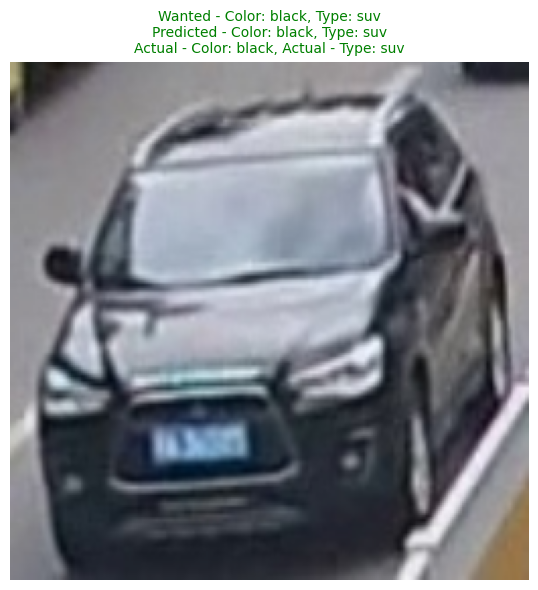

In [30]:
import random
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def search_image_by_color_and_type(model, dataloader, device=device, color_input=None, type_input=None, num_images=1):
    model.eval()  # Imposta il modello in modalità di valutazione
    random.seed(42)  # Per riproducibilità
    images_checked = 0
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    ])  # Trasformazione per riportare l'immagine originale

    plt.figure(figsize=(8, 6))  # Imposta dimensione della griglia per una sola immagine

    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        for images, labels in dataloader:
            # Sposta immagini e etichette su device
            images = images.to(device)
            color_labels = labels["color_id"].to(device)
            type_labels = labels["type_id"].to(device)

            # Predizione del modello
            color_logits, type_logits = model(images)
            _, predicted_color = color_logits.max(1)
            _, predicted_type = type_logits.max(1)

            # Itera sulle immagini di questo batch
            for i in range(images.size(0)):
                if (color_input is not None and predicted_color[i].item() == color_input) and \
                   (type_input is not None and predicted_type[i].item() == type_input):
                    # Se il colore e il tipo corrispondono, mostra questa immagine
                    img = images[i].cpu()
                    img = unnormalize(img)
                    img = img.permute(1, 2, 0).clamp(0, 1).numpy()  # Cambia ordine dimensioni per plt.imshow

                    # Determina se la predizione è corretta per il colore
                    correct_color = predicted_color[i].item() == color_labels[i].item()
                    correct_type = predicted_type[i].item() == type_labels[i].item()

                    # Colore del titolo in base alla correttezza della predizione
                    title_color = 'green' if correct_color and correct_type else 'red'
                    title = (
                        f"Wanted - Color: {color_mapping[color_input]}, Type: {type_mapping[type_input]}\n"
                        f"Predicted - Color: {color_mapping[predicted_color[i].item()]}, Type: {type_mapping[predicted_type[i].item()]}\n"
                        f"Actual - Color: {color_mapping[color_labels[i].item()]}, Actual - Type: {type_mapping[type_labels[i].item()]}")

                    # Mostra l'immagine
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(title, color=title_color, fontsize=10)

                    images_checked += 1
                    if images_checked >= num_images:
                        # Mostra l'immagine trovata e termina
                        plt.tight_layout()
                        plt.show()
                        return

    # Se non trova immagini che corrispondono ai criteri
    print(f"No images found with Color ID {color_input} and Type ID {type_input}.")

# Color map: {1: 'yellow', 2: 'orange', 3: 'green', 4: 'gray', 5: 'red', 6: 'blue', 7: 'white', 8: 'golden', 9: 'brown', 10: 'black'}
# Type map: {1: 'sedan', 2: 'suv', 3: 'van', 4: 'hatchback', 5: 'mpv', 6: 'pickup', 7: 'bus', 8: 'truck', 9: 'estate'}
color_input = 10  # ID del colore che vuoi filtrare
type_input = 2   # ID del tipo che vuoi filtrare
new_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
search_image_by_color_and_type(model, new_test_loader, color_input=color_input, type_input=type_input)
